<a href="https://colab.research.google.com/github/alexDahersh/Data-Science-fund./blob/main/Alex_H_Unit5ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

##Leverage

Let's take a look at the full basketball data set.

In [ ]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

Before, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [ ]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [ ]:
basketball

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

Text(0, 0.5, 'FG%')

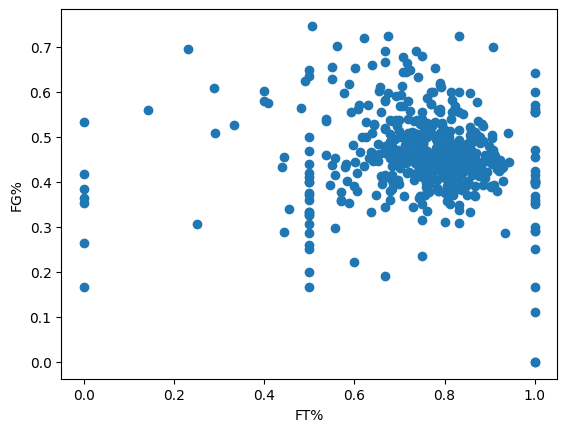

In [ ]:
#make scatter plot of FT% and FG% for NBA players form the 23/24 season
plt.scatter(basketball['FT%'] , basketball['FG%'],)

#label axes
plt.xlabel("FT%")
plt.ylabel("FG%")

There seems to be a cluster around .8 FT% and .45 FG%. Most of the other points are either 0, .5, or 1.0 FT%. The cluster is likely the standard for an NBA player and the weird FT%s are likely from people who don't take many shots.

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

In [ ]:
#this is an array of the basketball positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = basketball.Pos.cat.codes.values

#an array of the strings that represent position
pos_codes = basketball.Pos.cat.categories

#puts coords in a dict, so pymc can read them
bb_coords = {"pos": pos_codes}

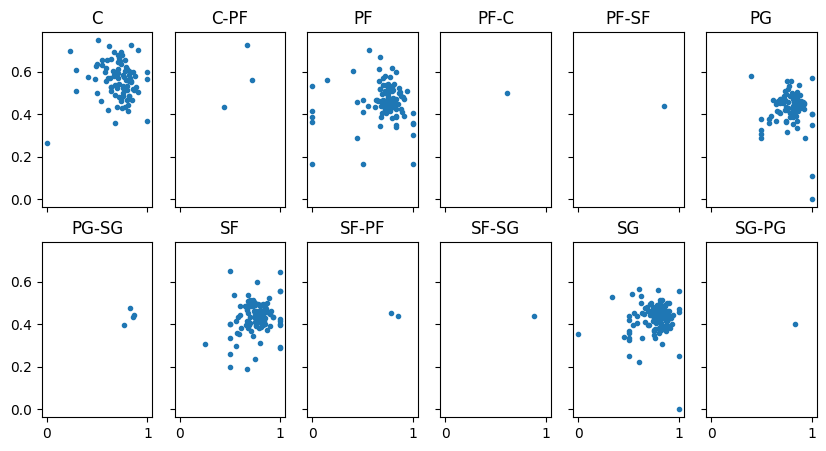

In [ ]:
#set up the 12 plots
_, ax = plt.subplots(2, 6, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

#make a scatter plot for each position
for i, p in enumerate(pos_codes):
    ax[i].scatter(
        x = basketball.query('Pos == @p')['FT%'],
        y =  basketball.query('Pos == @p')['FG%'],
        marker=".")
    ax[i].set_title(f"{p}")

**Task3**:

Originally, I was going to get you to create and run an individual linear regression model for each of the positions.

But I couldn't even get model to run.

Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

Or: if you do what I could not and get a linear regression model to run on the full data set, I'll give you full credit and a high five.

The main problem with getting the model to run seems to be 0s in FGA and FTA which result in FG% or FT% being nan. I'm going to use a binomial distribution as my likelihood so 0 FGA doesn't matter and I'll just assume 0 free throw attempts is a .5 FT%. This is a slightly faulty assumption, but must be done to use the data.

Using a binomial distribution as the likelihood also makes outliers (or points with high leverage) not affect the outcome as much.

In [ ]:
#nh for non hierarchical
with pm.Model(coords=bb_coords) as nh_model:
    #priors
    α = pm.Beta("α", alpha=2, beta=2, dims="pos")
    β = pm.Normal("β", mu=0, sigma=.5, dims="pos")
    σ = pm.HalfNormal("σ", 1)

    # the linear part. the formula
    pDet = pm.Deterministic('pDet', α[pos_idx] + β[pos_idx] * (basketball['FT']+.001)/(basketball['FTA']+.002)) # assuming no fta is .5 ft%, have to do this since I must use all the data


    # for players
    bet = pm.TruncatedNormal('bet', mu=pDet, sigma=σ, lower=0, upper=1)


    #likelihood
    y = pm.Binomial("y_pred",
                  p=bet,
                  n=basketball['FGA'],
                  observed=basketball['FG'])
    idata_nh_b = pm.sample()

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/

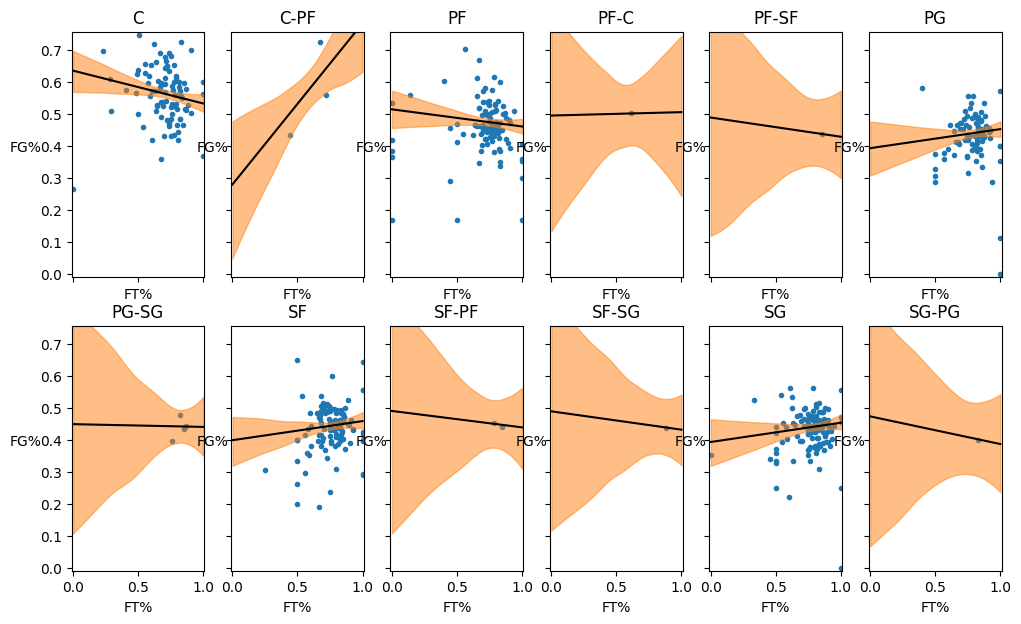

In [ ]:
#set out our 12 plots
_, ax = plt.subplots(2, 6, figsize=(12, 7), sharex=True, sharey=True)
ax = np.ravel(ax)

#set up x values. Used to graph line of best fit
x_range = np.linspace(basketball['FT%'].min(), basketball['FT%'].max(), 10)

#grab posterior info
posterior = az.extract(idata_nh_b)

#for each position
for i, p in enumerate(pos_codes):
    #plot the raw data
    ax[i].scatter(
        x = basketball.query('Pos == @p')['FT%'],
        y = basketball.query('Pos == @p')['FG%'],
        marker=".")

    #gives our graphs titles and labels
    ax[i].set_title(f"{p}")
    ax[i].set_xlabel("FT%")
    ax[i].set_ylabel("FG%", labelpad=10, rotation=0)

    #grab the slope and y-int
    alphas = posterior["α"].sel(pos=p)
    betas = posterior["β"].sel(pos=p)
    alpha_m = alphas.mean("sample").item()
    beta_m = betas.mean("sample").item()

    #plot the mean line, or line of best fit
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c="k")

    #plot a 94% HDI of the line of best fit.
    az.plot_hdi(x_range, alphas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])

    #set the limits of our graphs' window
    plt.xlim(basketball['FT%'].min() - 0.01, basketball['FT%'].max() + 0.01)
    plt.ylim(basketball['FG%'].min() - 0.01, basketball['FG%'].max() + 0.01)

## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [ ]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [ ]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


**Task4**:

Make a scatter plot of height versus weight for the howell data set.

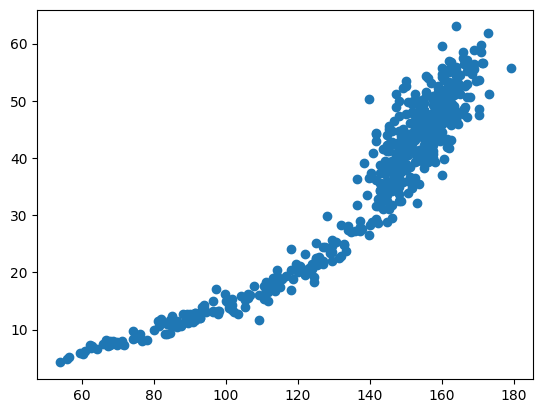

In [ ]:
plt.scatter(howell.height,howell.weight)

**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

In [ ]:
with pm.Model() as model_lba:

    #priors for our mean line
    #the default mean for a normal dist is 0
    α = pm.Normal("α", mu=0, sigma=10)
    β = pm.Normal("β", mu=0, sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * howell.height)

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    idata_lba = pm.sample()

Output()

Output()

array([<Axes: >], dtype=object)

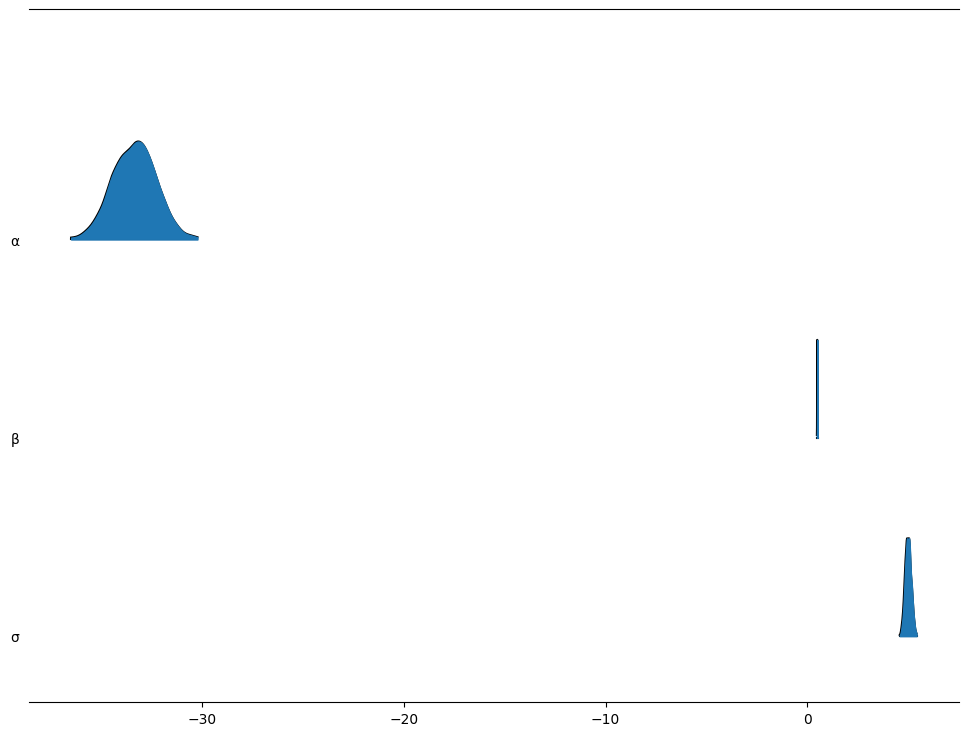

In [ ]:
az.plot_forest(idata_lba, kind="ridgeplot", var_names=['α','β','σ'], combined=True, figsize=(12, 9), hdi_prob=0.997)

Alpha is around -35 and beta is about .2 (+- 1). This already serves as a warning that this model is bad because a baby that has 0 height should not have a negative weight. A baby should never have negative weight in fact.

Text(0, 0.5, 'weight')

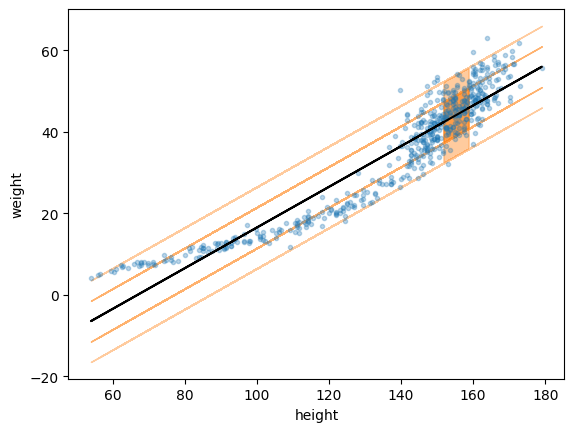

In [ ]:
_, ax = plt.subplots()

ax.plot(howell.height, howell.weight, "C0.", alpha=0.3)

posterior_lba = az.extract(idata_lba)

μ_m = posterior_lba["μ"].mean("sample").values
σ_m = posterior_lba["σ"].mean("sample").values

ax.plot(howell.height, μ_m, c="k")
ax.fill_between(howell.height, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(howell.height, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")


ax.set_xlabel("height")
ax.set_ylabel("weight")

The data points seem to mostly fit into the variability of the prediction but otherwise this model does a bad job.

**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

Output()

<Axes: xlabel='y_pred'>

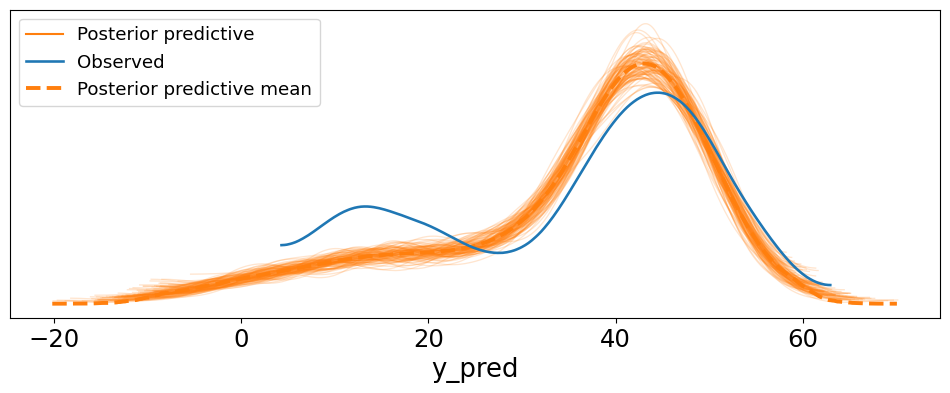

In [ ]:
pm.sample_posterior_predictive(idata_lba, model=model_lba, extend_inferencedata=True)
az.plot_ppc(idata_lba, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

The model has a pretty bad ppc. It somewhat models the higher peak but fails to model the second peak in the ppc. Also, the posterior of the model is either too high or too low compared to the data.  

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

In [ ]:
with pm.Model() as model_lba:

    #priors for our mean line
    #the default mean for a normal dist is 0
    α = pm.Normal("α", mu=0, sigma=3)
    β = pm.Normal("β", mu=0, sigma=.1)


    #mean line
    μ = pm.Deterministic("μ", pm.math.exp(α + β * howell.height)) # the data looked exponential

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 1)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ*howell.height, observed=howell.weight)

    idata_lba = pm.sample()

Output()

Output()

array([<Axes: >], dtype=object)

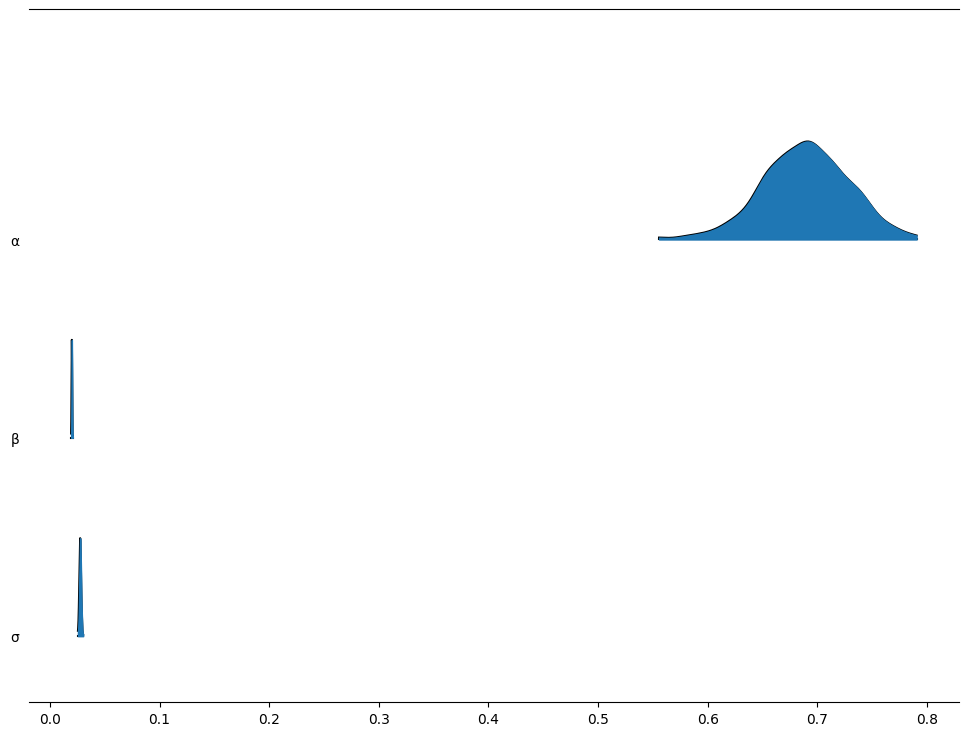

In [ ]:
az.plot_forest(idata_lba, kind="ridgeplot", var_names=['α','β','σ'], combined=True, figsize=(12, 9), hdi_prob=0.997)

**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

Text(0, 0.5, 'weight')

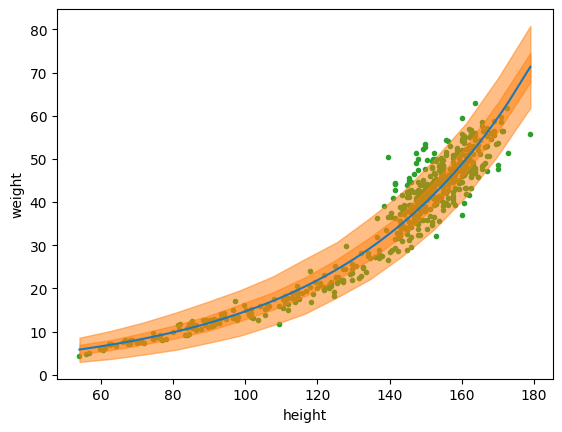

In [ ]:
mean_line = idata_lba.posterior["μ"].mean(("chain", "draw"))
heights = np.random.normal(howell.height.values, 0.01)
idx = np.argsort(heights)
x = np.linspace(heights.min(), heights.max(), 15)
y_pred_q = idata_lba.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(heights[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)
ax.plot(howell.height[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("height")
ax.set_ylabel("weight")


Output()

<Axes: xlabel='y_pred'>

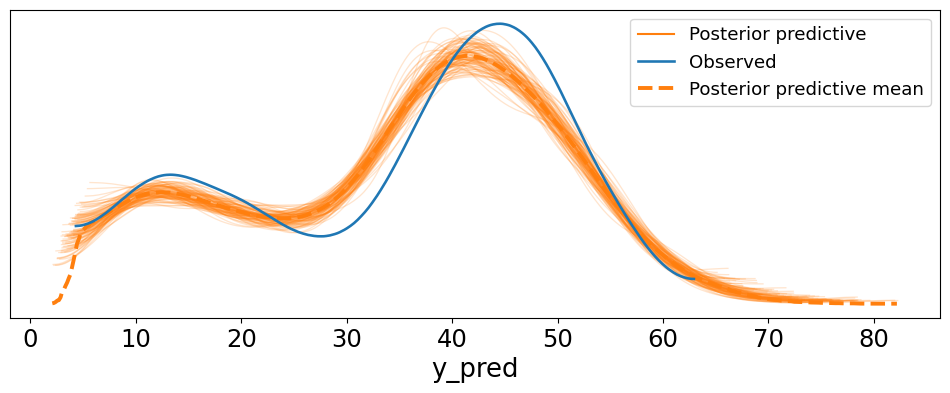

In [ ]:
pm.sample_posterior_predictive(idata_lba, model=model_lba, extend_inferencedata=True)
az.plot_ppc(idata_lba, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

This model seems to do a much better job. The model somewhat successfully models both peaks in the ppc and seems to correctly predict the mean of the relationship between height and weight. The model does fail to correctly model the variability.

# Extra

Pymc samples weirdly. One chain is great and the other sucks.

In [ ]:
with pm.Model() as model_lba:

    #priors for our mean line
    #the default mean for a normal dist is 0
    α = pm.Normal("α", mu=0, sigma=10)
    β = pm.Normal("β", mu=0, sigma=10)


    #mean line
    μ = pm.Deterministic("μ", pm.math.exp(α + β * howell.height))

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 1)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ*howell.height, observed=howell.weight)

    idata_lba = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:There were 623 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

<Axes: xlabel='y_pred'>

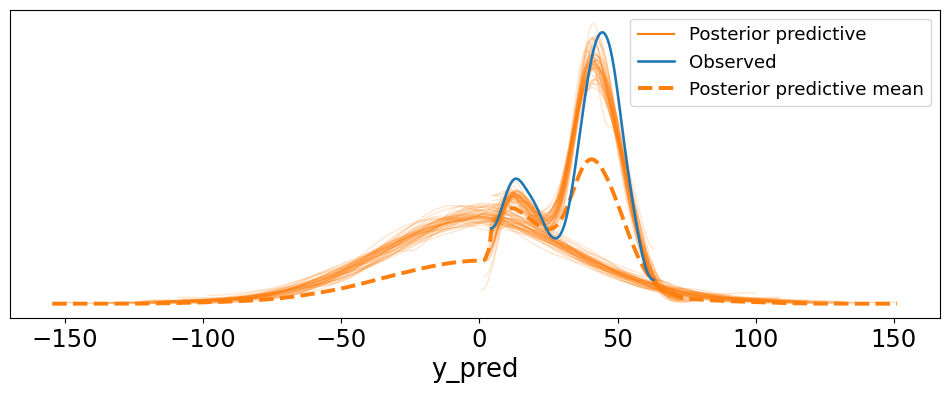

In [ ]:
pm.sample_posterior_predictive(idata_lba, model=model_lba, extend_inferencedata=True)
az.plot_ppc(idata_lba, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])